In [ ]:
Session 2

In [30]:
suppressWarnings(library(tidyverse))
suppressWarnings(library(knitr))
suppressWarnings(library(dplyr))
suppressWarnings(library(ggplot2))
suppressWarnings(library(IRdisplay))

session <- list()
for(i in 1:18){
  session[[i]] <- readRDS(paste('./Data/session', i, '.rds', sep = ''))
}

In [34]:
meta <- tibble(
  mouse_name = character(),
  date_exp = character(),
  n_brain_area = integer(),
  n_neurons = integer(),
  n_trials = integer(),
  success_rate = numeric()
)

for(i in 1:18){
  tmp <- session[[i]]
  meta <- meta %>% add_row(
    mouse_name = tmp$mouse_name,
    date_exp = tmp$date_exp,
    n_brain_area = length(unique(tmp$brain_area)),
    n_neurons = dim(tmp$spks[[1]])[1],
    n_trials = length(tmp$feedback_type),
    success_rate = mean(tmp$feedback_type + 1) / 2
  )
}

print(kable(meta))



|mouse_name |date_exp   | n_brain_area| n_neurons| n_trials| success_rate|
|:----------|:----------|------------:|---------:|--------:|------------:|
|Cori       |2016-12-14 |            8|       734|      114|    0.6052632|
|Cori       |2016-12-17 |            5|      1070|      251|    0.6334661|
|Cori       |2016-12-18 |           11|       619|      228|    0.6622807|
|Forssmann  |2017-11-01 |           11|      1769|      249|    0.6666667|
|Forssmann  |2017-11-02 |           10|      1077|      254|    0.6614173|
|Forssmann  |2017-11-04 |            5|      1169|      290|    0.7413793|
|Forssmann  |2017-11-05 |            8|       584|      252|    0.6706349|
|Hench      |2017-06-15 |           15|      1157|      250|    0.6440000|
|Hench      |2017-06-16 |           12|       788|      372|    0.6854839|
|Hench      |2017-06-17 |           13|      1172|      447|    0.6196868|
|Hench      |2017-06-18 |            6|       857|      342|    0.7953216|
|Lederberg  |2017-12-05

In [37]:
# Compute average spikes per trial for each session

for(i in 1:18){
  n.trials <- length(session[[i]]$feedback_type)
  avg.spks.all <- numeric(n.trials)
  for(j in 1:n.trials){
    spks.trial <- session[[i]]$spks[[j]]
    total.spikes <- apply(spks.trial, 1, sum)
    avg.spks.all[j] <- mean(total.spikes)
  }
  session[[i]]$avg.spks <- avg.spks.all
}

In [39]:
# Combine trial data across sessions into one data frame

trials.all <- tibble()
for(s in 1:18){
  n.trials <- length(session[[s]]$feedback_type)
  tmp <- session[[s]]
  trials <- tibble(
    session_ID = s,
    mouse_name = tmp$mouse_name,
    trial_ID = 1:n.trials,
    avg_spks = tmp$avg.spks,
    contrast_left = tmp$contrast_left,
    contrast_right = tmp$contrast_right,
    feedback_type = tmp$feedback_type
  )
  trials.all <- bind_rows(trials.all, trials)
}
head(trials.all)

session_ID,mouse_name,trial_ID,avg_spks,contrast_left,contrast_right,feedback_type
<int>,<chr>,<int>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
1,Cori,1,1.581744,0.0,0.5,1
1,Cori,2,1.311989,0.0,0.0,1
1,Cori,3,1.844687,0.5,1.0,-1
1,Cori,4,1.381471,0.0,0.0,-1
1,Cori,5,1.425068,0.0,0.0,-1
1,Cori,6,1.094005,0.0,0.0,1


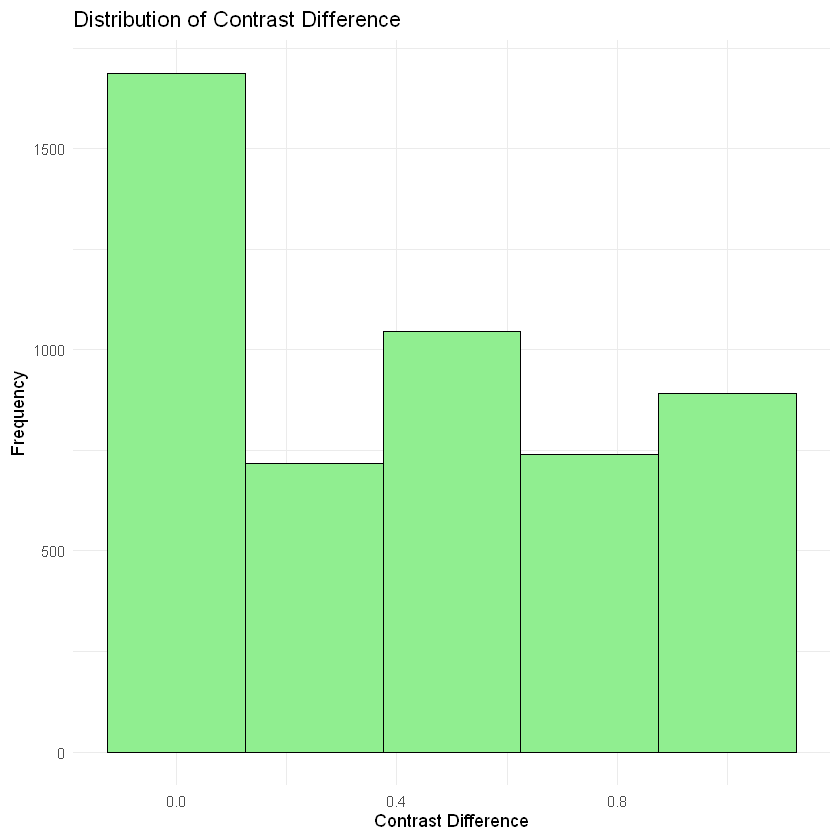

In [108]:
# Visualize contrast difference distribution

integrated_trials <- trials.all %>% 
  mutate(contrast_diff = abs(contrast_left - contrast_right))
ggplot(integrated_trials, aes(x = contrast_diff)) +
  geom_histogram(bins = 5, fill = "lightgreen", color = "black") +
  theme_minimal() +
  ggtitle("Distribution of Contrast Difference") +
  xlab("Contrast Difference") +
  ylab("Frequency")

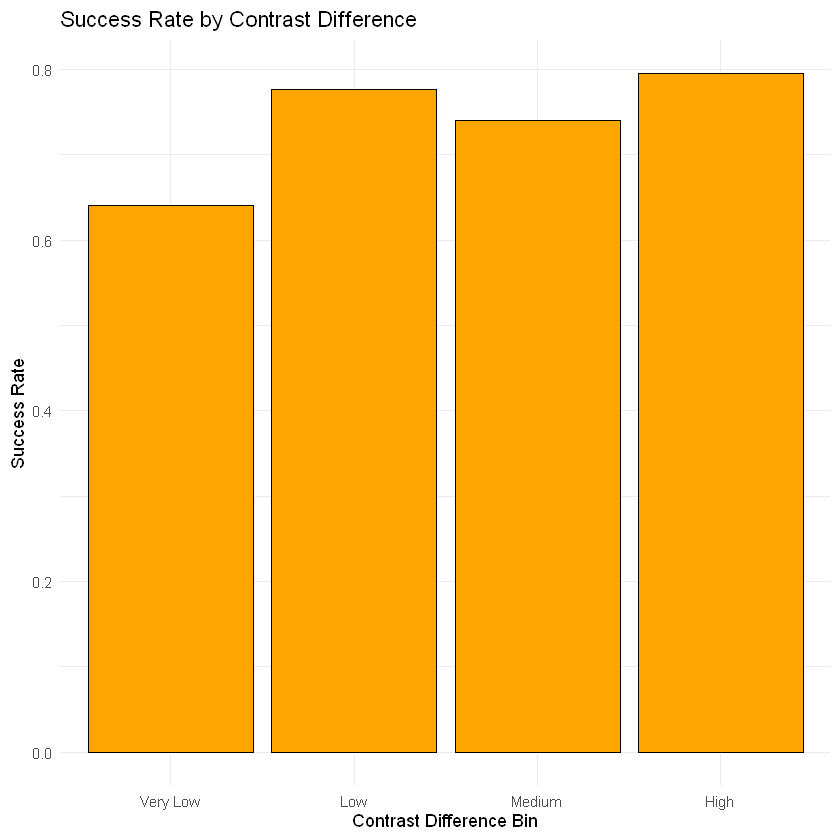

In [125]:
# Plot success rate by contrast difference bins

integrated_trials <- integrated_trials %>% 
  mutate(contrast_bin = cut(
  contrast_diff,
  breaks = c(0, 0.25, 0.5, 0.75, 1.0),
  labels = c("Very Low", "Low", "Medium", "High"),
  include.lowest = TRUE
))

success_by_contrast <- integrated_trials %>% 
  group_by(contrast_bin) %>% 
  summarize(success_rate = mean(feedback_type == 1), .groups = "drop")
ggplot(success_by_contrast, aes(x = contrast_bin, y = success_rate)) +
  geom_bar(stat = "identity", fill = "orange", color = "black") +
  theme_minimal() +
  ggtitle("Success Rate by Contrast Difference") +
  xlab("Contrast Difference Bin") +
  ylab("Success Rate")

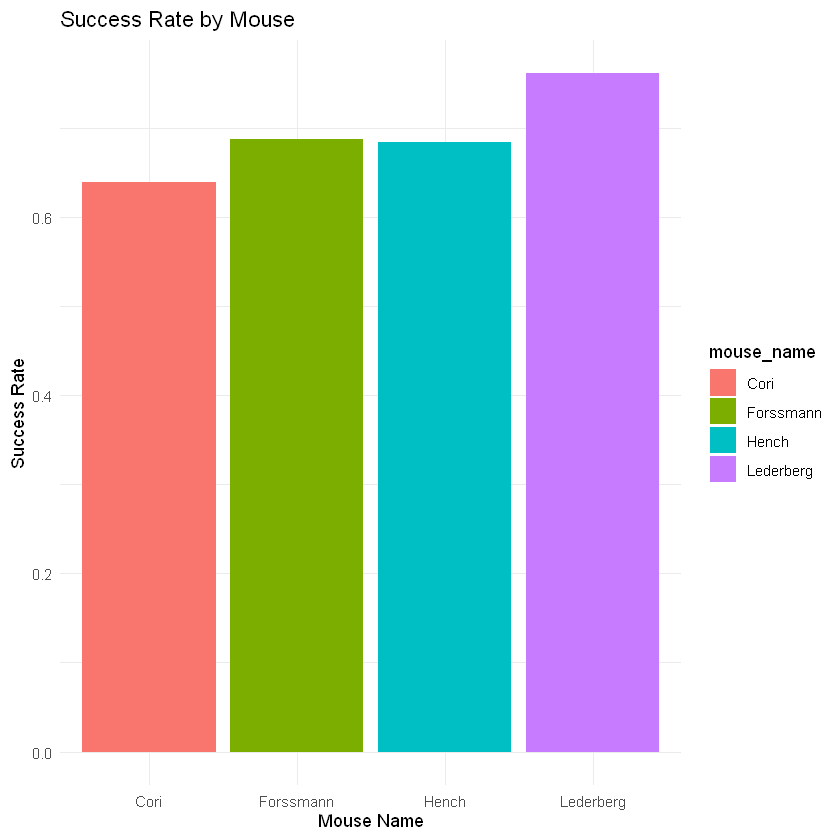

In [51]:
# Plot success rate by mouse

success_by_mouse <- integrated_trials %>% 
  group_by(mouse_name) %>% 
  summarize(success_rate = mean(feedback_type == 1), .groups = "drop")
ggplot(success_by_mouse, aes(x = mouse_name, y = success_rate, fill = mouse_name)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  ggtitle("Success Rate by Mouse") +
  xlab("Mouse Name") +
  ylab("Success Rate")

Session 3

In [57]:
#Identify all unique brain areas across sessions

all_brain_areas <- unique(unlist(lapply(session, function(s) unique(s$brain_area))))
all_brain_areas <- sort(all_brain_areas)
print(all_brain_areas)

 [1] "ACA"   "ACB"   "AUD"   "BLA"   "CA1"   "CA3"   "CP"    "DG"    "EPd"  
[10] "GPe"   "ILA"   "LD"    "LGd"   "LH"    "LP"    "LS"    "LSc"   "LSr"  
[19] "MB"    "MD"    "MEA"   "MG"    "MOp"   "MOs"   "MRN"   "MS"    "NB"   
[28] "OLF"   "ORB"   "ORBm"  "OT"    "PAG"   "PIR"   "PL"    "PO"    "POL"  
[37] "POST"  "PT"    "RN"    "root"  "RSP"   "RT"    "SCm"   "SCs"   "SCsg" 
[46] "SI"    "SNr"   "SPF"   "SSp"   "SSs"   "SUB"   "TH"    "TT"    "VISa" 
[55] "VISam" "VISl"  "VISp"  "VISpm" "VISrl" "VPL"   "VPM"   "ZI"   


In [59]:
# Create integrated data with brain area features for each trial 

integrated_data <- tibble()
for(s in 1:18){
  n.trials <- length(session[[s]]$feedback_type)
  tmp <- session[[s]]
  brain_areas_session <- tmp$brain_area
  for(trial in 1:n.trials){
    spks_trial <- tmp$spks[[trial]]
    total_spikes <- apply(spks_trial, 1, sum)
    brain_area_features <- setNames(rep(0, length(all_brain_areas)), paste0("brain_area_", all_brain_areas))
    for(area in unique(brain_areas_session)){
      idx <- which(brain_areas_session == area)
      if(length(idx) > 0){
         brain_area_features[paste0("brain_area_", area)] <- mean(total_spikes[idx])
      }
    }
    trial_info <- tibble(
      session_ID = s,
      trial_ID = trial,
      mouse_name = tmp$mouse_name,
      contrast_left = tmp$contrast_left[trial],
      contrast_right = tmp$contrast_right[trial],
      feedback_type = tmp$feedback_type[trial],
      avg_spks = tmp$avg.spks[trial]
    )
    trial_features <- as_tibble(as.list(brain_area_features))
    trial_combined <- bind_cols(trial_info, trial_features)
    integrated_data <- bind_rows(integrated_data, trial_combined)
  }
}
head(integrated_data)


session_ID,trial_ID,mouse_name,contrast_left,contrast_right,feedback_type,avg_spks,brain_area_ACA,brain_area_ACB,brain_area_AUD,⋯,brain_area_TT,brain_area_VISa,brain_area_VISam,brain_area_VISl,brain_area_VISp,brain_area_VISpm,brain_area_VISrl,brain_area_VPL,brain_area_VPM,brain_area_ZI
<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Cori,0.0,0.5,1,1.581744,1.2660550,0,0,⋯,0,0,0,0,1.685393,0,0,0,0,0
1,2,Cori,0.0,0.0,1,1.311989,0.5871560,0,0,⋯,0,0,0,0,1.651685,0,0,0,0,0
1,3,Cori,0.5,1.0,-1,1.844687,1.1926606,0,0,⋯,0,0,0,0,2.275281,0,0,0,0,0
1,4,Cori,0.0,0.0,-1,1.381471,0.5137615,0,0,⋯,0,0,0,0,1.561798,0,0,0,0,0
1,5,Cori,0.0,0.0,-1,1.425068,0.7706422,0,0,⋯,0,0,0,0,1.623596,0,0,0,0,0
1,6,Cori,0.0,0.0,1,1.094005,0.4587156,0,0,⋯,0,0,0,0,1.280899,0,0,0,0,0


In [61]:
# Add additional features to integrated data

integrated_data <- integrated_data %>% 
  mutate(contrast_diff = abs(contrast_left - contrast_right),
         decision = case_when(
           contrast_left > contrast_right ~ "Left",
           contrast_left < contrast_right ~ "Right",
           contrast_left == contrast_right & contrast_left == 0 ~ "No Stimulus",
           TRUE ~ "Equal Nonzero"
         ))
head(integrated_data)


session_ID,trial_ID,mouse_name,contrast_left,contrast_right,feedback_type,avg_spks,brain_area_ACA,brain_area_ACB,brain_area_AUD,⋯,brain_area_VISam,brain_area_VISl,brain_area_VISp,brain_area_VISpm,brain_area_VISrl,brain_area_VPL,brain_area_VPM,brain_area_ZI,contrast_diff,decision
<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,Cori,0.0,0.5,1,1.581744,1.2660550,0,0,⋯,0,0,1.685393,0,0,0,0,0,0.5,Right
1,2,Cori,0.0,0.0,1,1.311989,0.5871560,0,0,⋯,0,0,1.651685,0,0,0,0,0,0.0,No Stimulus
1,3,Cori,0.5,1.0,-1,1.844687,1.1926606,0,0,⋯,0,0,2.275281,0,0,0,0,0,0.5,Right
1,4,Cori,0.0,0.0,-1,1.381471,0.5137615,0,0,⋯,0,0,1.561798,0,0,0,0,0,0.0,No Stimulus
1,5,Cori,0.0,0.0,-1,1.425068,0.7706422,0,0,⋯,0,0,1.623596,0,0,0,0,0,0.0,No Stimulus
1,6,Cori,0.0,0.0,1,1.094005,0.4587156,0,0,⋯,0,0,1.280899,0,0,0,0,0,0.0,No Stimulus


Session 4

In [63]:
set.seed(1)
sample_idx <- sample(seq_len(nrow(integrated_data)), size = floor(0.8 * nrow(integrated_data)))
train_data <- integrated_data[sample_idx, ]
test_data <- integrated_data[-sample_idx, ]

In [65]:
brain_cols <- names(train_data)[grep("^brain_area_", names(train_data))]
predictors <- c("contrast_left", "contrast_right", "avg_spks", "contrast_diff", "decision", "session_ID", brain_cols)
formula_str <- as.formula(paste("as.factor(feedback_type) ~", paste(predictors, collapse = " + ")))
model <- glm(formula_str, data = train_data, family = "binomial")
summary(model)


Call:
glm(formula = formula_str, family = "binomial", data = train_data)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.621588   0.510648  -5.134 2.84e-07 ***
contrast_left       -0.196338   0.209575  -0.937 0.348841    
contrast_right      -1.249599   0.221914  -5.631 1.79e-08 ***
avg_spks             3.053185   0.552276   5.528 3.23e-08 ***
contrast_diff        1.260918   0.203327   6.201 5.60e-10 ***
decisionLeft         0.191534   0.235930   0.812 0.416892    
decisionNo Stimulus  0.452040   0.207202   2.182 0.029136 *  
decisionRight        0.541075   0.230781   2.345 0.019051 *  
session_ID           0.026544   0.045619   0.582 0.560650    
brain_area_ACA       0.202724   0.438748   0.462 0.644046    
brain_area_ACB       1.972974   1.776974   1.110 0.266870    
brain_area_AUD       0.880867   0.993074   0.887 0.375073    
brain_area_BLA      -2.828357   0.695008  -4.070 4.71e-05 ***
brain_area_CA1       0.609506   0.206464   

Session 5

In [68]:
pred_prob <- predict(model, newdata = test_data, type = "response")
pred_class <- ifelse(pred_prob > 0.5, 1, -1)
accuracy <- mean(pred_class == test_data$feedback_type)
print(paste("Test Accuracy:", accuracy))


[1] "Test Accuracy: 0.71779744346116"


[1] "AUC: 0.667435847399747"


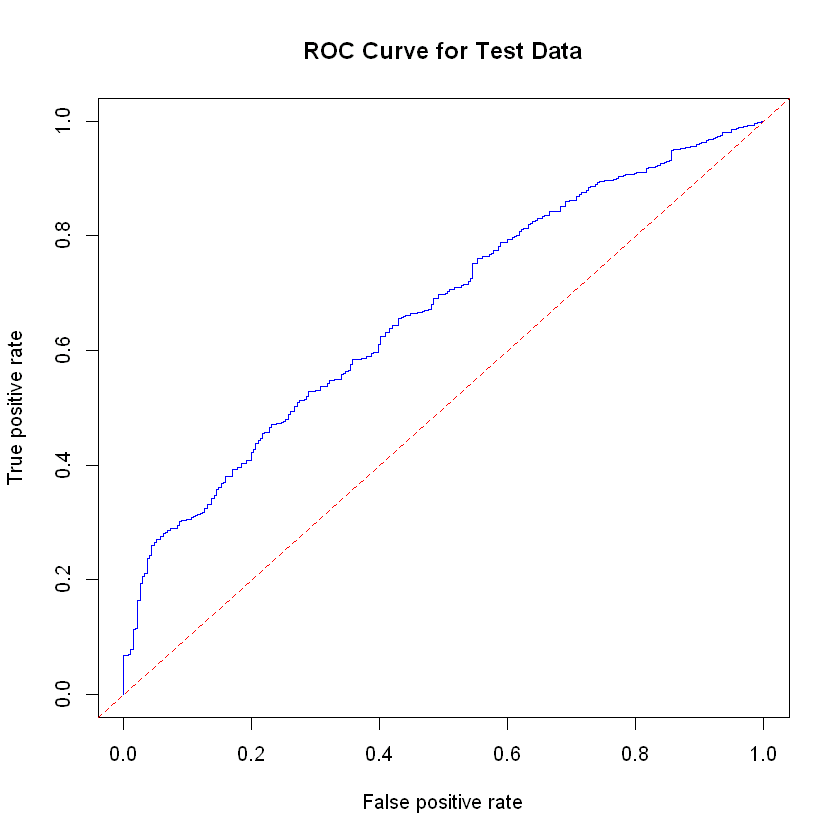

In [70]:
suppressWarnings(library(ROCR))
pred_obj <- prediction(pred_prob, test_data$feedback_type)
perf_obj <- performance(pred_obj, "tpr", "fpr")
plot(perf_obj, col = "blue", main = "ROC Curve for Test Data")
abline(a = 0, b = 1, lty = 2, col = "red")
auc <- performance(pred_obj, "auc")
auc_value <- auc@y.values[[1]]
print(paste("AUC:", auc_value))


In [74]:
suppressWarnings(library(caret))
test_data <- test_data %>% mutate(pred_class = factor(pred_class, levels = c(-1, 1)),
                                    feedback_factor = factor(feedback_type, levels = c(-1, 1)))
cm <- confusionMatrix(test_data$pred_class, test_data$feedback_factor)
print(cm)


Confusion Matrix and Statistics

          Reference
Prediction  -1   1
        -1  44  54
        1  233 686
                                         
               Accuracy : 0.7178         
                 95% CI : (0.689, 0.7453)
    No Information Rate : 0.7276         
    P-Value [Acc > NIR] : 0.771          
                                         
                  Kappa : 0.1076         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.15884        
            Specificity : 0.92703        
         Pos Pred Value : 0.44898        
         Neg Pred Value : 0.74646        
             Prevalence : 0.27237        
         Detection Rate : 0.04326        
   Detection Prevalence : 0.09636        
      Balanced Accuracy : 0.54294        
                                         
       'Positive' Class : -1             
                                         
